# All Ireland M.bovis strain diversity and clade identification

In [1]:
import sys,os,io,shutil,subprocess
import glob
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
import pylab as plt
import matplotlib as mpl
from Bio import SeqIO
import seaborn as sns
sys.path.append('pathogenie')
from snipgenie import tools, aligners, app, trees, plotting, rdiff
#import toytree, toyplot
#import toyplot.pdf
path = '/storage/btbgenie/all_ireland_results'

## get meta data

In [2]:
meta = pd.read_csv('/storage/btbgenie/mbovis_ireland/all_ireland_samples.csv')
print (len(meta))

973


In [ ]:
dups=meta[meta.duplicated('aliquot')].dropna()
#print (dups)
for i,r in dups.iterrows():
    print (meta[meta.aliquot== r.aliquot])
#meta[(meta.batch.isin([2,3,4])) & (~meta.aliquot.isin(dups.aliquot)) & (meta.county=='Monaghan')]

## run NI

In [ ]:
reload(app)
args = {'threads':20, 'outdir': '/storage/btbgenie/NI_results', 'labelsep':'_',
        'input':['/storage/btbgenie/mbovis_ireland/NI/'],
         'species': 'Mbovis-AF212297',
         'overwrite':False,
         'custom_filters': True,
         'buildtree':True}
W = app.WorkFlow(**args)
st = W.setup()
W.run()

## misc samples (Kevin, non-Monaghan)

In [ ]:
reload(app)
args = {'threads':12, 'outdir': '/storage/btbgenie/misc_results', 'labelsep':'_',
        'input':['/storage/btbgenie/mbovis_ireland/Misc'],
         'species': 'Mbovis-AF212297',
         'overwrite':False,
         'custom_filters': True,
         'get_stats':False,
         'buildtree':True}
W = app.WorkFlow(**args)
st = W.setup()
W.run()

In [ ]:
reload(app)
mask='/home/farrell/gitprojects/snipgenie/snipgenie/data/Mbovis_AF212297_mask.bed'
vcf_file='/storage/btbgenie/misc_results/snps.vcf.gz'
app.mask_filter(vcf_file, mask)

In [244]:
present=pd.read_csv('/storage/btbgenie/misc_results/summary.csv')
present['sample']=present['sample'].astype(str)
#print (present[:10])
l=list(W.fastq_table['sample'].unique())

s=meta[meta.batch>=3].sort_values(by='sample')
#s['label'] = s['sample'].apply(lambda x : x.split('-')[1][-4:]).astype(str)
#s=s.sort_values('label')

p = present[~present['sample'].isin(s['sample'])]
#p = (s[s['label'].isin(l)])
print (p)
print (len(s),len(p), len(present))

         sample                           name                                           bam_file  read_length
25  TB19-004280  TB19-004280_S68_L001-4_R2_001  /storage/btbgenie/misc_results/mapped/TB19-004...          149
48  TB19-005887  TB19-005887_S29_L001-4_R2_001  /storage/btbgenie/misc_results/mapped/TB19-005...          150
65 2 61


In [284]:
reload(trees)
spo=pd.read_csv('/storage/btbgenie/all_ireland_results/misc_spoligotypes.csv')
treefile = '/storage/btbgenie/misc_results/tree.newick'
tre = toytree.tree(treefile)
tipnames = tre.get_tip_labels()
mapping = dict(zip(meta['sample'],meta.county))
colormap = trees.colors_from_labels(meta,'name','county')
tip_colors = [colormap[mapping[i]] if i in mapping else 'Black' for i in tipnames]

canvas,t,r=tre.draw(layout='r',width=1000,height=1000,tip_labels_colors=tip_colors,
                    scalebar=True,);
toyplot.pdf.render(canvas,'/storage/btbgenie/all_ireland_results/misc_samples_tree.pdf')

## run CVRL samples

In [ ]:
args = {'threads':20, 'outdir': '/storage/btbgenie/cvrl_results', 'labelsep':'_',
        'input':['/storage/btbgenie/mbovis_ireland/CVRL'],
         'species': 'Mbovis-AF212297',
         'overwrite':False,
         'custom_filters': True,
         'buildtree':True}
W = app.WorkFlow(**args)
st = W.setup()
W.run()

## UK samples?

In [ ]:
args = {'threads':20, 'outdir': '/storage/btbgenie/UK_results', 'labelsep':'_',
        'input':['/storage/btbgenie/??'],
         'species': 'Mbovis-AF212297',
         'overwrite':False,
         'custom_filters': True,
         'buildtree':True}
W = app.WorkFlow(**args)
st = W.setup()
W.run()

In [ ]:
reload(trees)
spo=pd.read_csv('/storage/btbgenie/all_ireland_results/cvrl_spoligotypes.csv')
treefile = '/storage/btbgenie/cvrl_results/tree.newick'
tre = toytree.tree(treefile)
tipnames = tre.get_tip_labels()
mapping = dict(zip(meta['sample'],meta.county))
colormap = trees.colors_from_labels(meta,'name','county')
tip_colors = [colormap[mapping[i]] if i in mapping else 'Black' for i in tipnames]

canvas,t,r=tre.draw(layout='r',width=1000,height=1400,tip_labels_colors=tip_colors,
                    scalebar=True,);

## integrate previously aligned bam files together and call variants

This allows us to join previously mapped results together in one call without re-aligning

In [4]:
outdir='/storage/btbgenie/all_ireland_results'

folders = {'wicklow':'/storage/btbgenie/wicklow_results',
          'cvrl':'/storage/btbgenie/cvrl_results',
          'misc':'/storage/btbgenie/misc_results',
          'monaghan':'/storage/btbgenie/monaghan/monaghan_results',
          'NI':'/storage/btbgenie/NI_results/'         
          }

x=[]
for f in folders:
    print (f)
    file = os.path.join(folders[f],'samples.csv')   
    df=pd.read_csv(file)
    x.append(df)
samples = pd.concat(x)
print (len(samples))
samples.to_csv('/storage/btbgenie/all_ireland_results/samples.csv',index=False)
app.write_samples(samples[['sample']], outdir)
bam_files = list(samples.bam_file)

wicklow
cvrl
misc
monaghan
NI
839


## run previously aligned files

In [ ]:
reload(app)
gff_file=os.path.join(outdir,'mbovis.gff')
tools.gff_bcftools_format(app.mbovis_gb, gff_file)
app.run_bamfiles(bam_files, app.mbovis_genome, outdir='/storage/btbgenie/all_ireland_results', threads=16,                
                 mask=app.mbovis_mask, gff_file=gff_file,
                 custom_filters=True)

## spoligotypes of all samples

In [ ]:
reload(tools)
spo = pd.read_csv('/storage/btbgenie/mbovis_ireland/spoligotypes.csv')
done=list(spo['sample'])
res=[]
for i,r in samples.iterrows():
    f=r.filename1
    samp=r['sample']
    if samp in done:
        continue
    b = tools.get_spoligotype(f)
    sb = tools.get_sb_number(b)
    print (f,samp,sb, b)
    res.append([f,samp,sb,b])
 
res = pd.DataFrame(res,columns=['filename','sample','SB','code'])
#append new spotypes to current file
res=pd.concat([spo,res])

In [6]:
len(res),len(meta)
#meta[~meta['sample'].isin(res['sample'])]
#res.to_csv('/storage/btbgenie/mbovis_ireland/spoligotypes.csv',index=False)

<div class="alert alert-block alert-info"><b>Post analysis starts here</b> </div>

## clusters

In [16]:
clusts = trees.get_clusters('/storage/btbgenie/all_ireland_results/tree.newick')

TreeCluster.py  -i /storage/btbgenie/all_ireland_results/tree.newick -t 3 -m max_clade
TreeCluster.py  -i /storage/btbgenie/all_ireland_results/tree.newick -t 5 -m max_clade
TreeCluster.py  -i /storage/btbgenie/all_ireland_results/tree.newick -t 7 -m max_clade
TreeCluster.py  -i /storage/btbgenie/all_ireland_results/tree.newick -t 10 -m max_clade
TreeCluster.py  -i /storage/btbgenie/all_ireland_results/tree.newick -t 12 -m max_clade
TreeCluster.py  -i /storage/btbgenie/all_ireland_results/tree.newick -t 20 -m max_clade
TreeCluster.py  -i /storage/btbgenie/all_ireland_results/tree.newick -t 50 -m max_clade
TreeCluster.py  -i /storage/btbgenie/all_ireland_results/tree.newick -t 100 -m max_clade


[5, 11, 16, 34, 25, 35, 36, 21, 31, -1, 26, 19, 20, 24, 15, 33, 12, 8, 13]


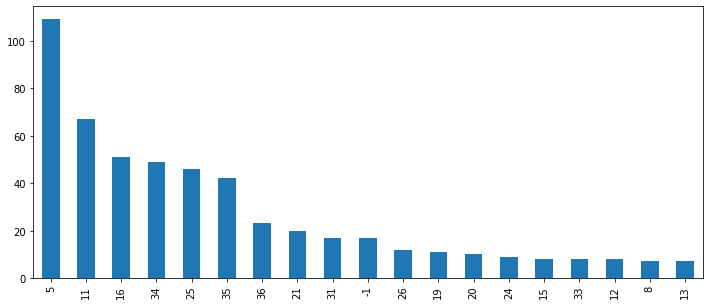

In [17]:
cc = clusts.snp50.value_counts()[1:20]
cc.plot(kind='bar',figsize=(12,5))
print (list(cc.index))

In [23]:
common = meta.county.value_counts()[:8]
def cty_comm(x):
    if x in common:
        return x
    else:
        return 'Other'
meta['county1'] = meta.county.apply(cty_comm)
meta['county2'] = meta.county.apply(lambda x : x if x in ['Monaghan','Clare'] else 'Other')
common

Monaghan     412
Clare        163
Armagh        91
Wicklow       53
Tyrone        41
Fermanagh     33
Cork          26
Galway        21
Name: county, dtype: int64

In [19]:
spo = pd.read_csv('/storage/btbgenie/mbovis_ireland/spoligotypes.csv')

In [25]:
final = meta.merge(spo[['sample','SB']],on='sample',how='left')
final = final.merge(clusts,left_on='sample',right_on='SequenceName')
len(final)

685

In [26]:
common = final.SB.value_counts()[:6]
def sb_comm(x):
    if x in common:
        return x
    else:
        return 'Other'
final['SB1'] = final.SB.apply(sb_comm)   

In [27]:
final.to_csv('/storage/btbgenie/all_ireland_results/metadata.csv',index=False)

## assign clade names - replace with lineage calling?

In [ ]:
import string
labels=list(string.ascii_uppercase)
clmap={}
found=[]
i=0
for c,g in final.groupby('ClusterNumber'):    
    if len(g)==0: continue
    cts = g.county.value_counts()
    top = cts[0]
    if top>10:         
        clmap[c]=labels[i]
        i+=1
    else:
        clmap[c]='Other'

## RD analysis

In [ ]:
reload(rdiff)
rdiff.create_rd_index()
samples = pd.read_csv('/storage/btbgenie/all_ireland_results/samples.csv')
res = rdiff.run_samples(samples,'/storage/btbgenie/all_ireland_results/rd_aligned',threads=12)
X = rdiff.get_matrix(res, cutoff=0.15)
X['ident'] = X.apply(rdiff.apply_rules,1)
#X.to_csv('/storage/btbgenie/mbovis_ireland/rd.csv')

In [ ]:
R=pd.read_csv('/storage/btbgenie/mbovis_ireland/rd.csv',index_col=0)
R=R.iloc[:,:-1]
#cols=X.columns[(X.sum()<len(X)-1) & (X.sum()>0)]
cols = ['RD1','RD1mic','RDWicklow','RD11','RD12bov','RD13','RD149','RD3','RD5','RD5oryx*','RD122','RDAf2']
R = R[cols]
#fig,ax=plt.subplots(1,1,figsize=(10,10))
sns.clustermap(R,cmap='gray_r',figsize=(10,10))

In [ ]:
reload(rdiff)
samples = pd.read_csv('/storage/btbgenie/all_ireland_results/samples.csv')
sub=samples.sample(20,random_state=2)
regions = rdiff.get_deletions(sub, app.mbovis_genome, app.mbovis_gb, mask_file=app.mbovis_mask,
                              label='sample', min_coverage=0, n_cores=12)
regions.to_csv('deletion_regions.csv',index=False)

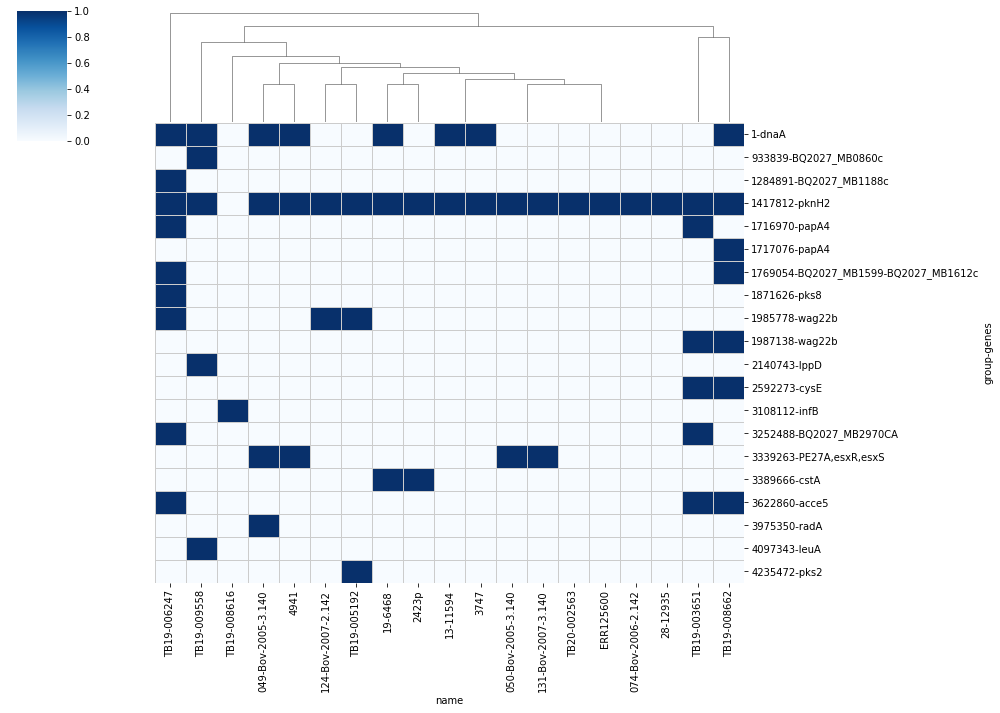

In [4]:
regions = pd.read_csv('deletion_regions.csv')
res=regions[regions.length>10]
X=pd.pivot_table(res,index=['group','genes'],columns='name',values='length').fillna(0)
X=X.clip(0,1)
X
sns.clustermap(X,cmap='Blues',row_cluster=False,yticklabels=True,lw=1,linecolor='.8',figsize=(14,10))

In [ ]:
reload(rdiff)
s=3339263;e=s+1000
rdiff.show_coverage(sub, 'LT708304.1',s,e,app.mbovis_genome,app.mbovis_gb,margin=1300)

## SNP analysis

* snps unique to each clade/county
* protein groups containing common snps

In [16]:
final = pd.read_csv('/storage/btbgenie/all_ireland_results/metadata.csv')
csq = app.read_csq_file('/storage/btbgenie/all_ireland_results/csq.tsv')
aamat = app.get_aa_snp_matrix(csq)
#csqind = app.read_csq_file('/storage/btbgenie/all_ireland_results/csq_indels.tsv')
#indmat = app.get_aa_snp_matrix(csq_ind)

## snps unique to a clade

In [17]:
reload(tools)
name='cat-003488'
tools.get_unique_snps(name, aamat)

,,,sample,cat-003488
start,gene,aa,snp_type,
1461929,rfe,393R>393C,missense,1
2753251,gdh,528A>528G,missense,1
2967659,BQ2027_MB2708c,151H>151R,missense,1
3057726,BQ2027_MB2810,552V>552E,missense,1
3355243,BQ2027_MB3060c,217S,synonymous,1


In [75]:
names = final[final.snp100==8]['sample']
u = tools.get_unique_snps(names, snpmat)
u = u.sum(1).reset_index().sort_values(0,ascending=False)
u.to_csv('wicklow_unique_snps.csv',index=False)

## plot clustermap of SNPs

In [ ]:
X=snpmat.sample(20)
#X=C.loc[:,['Wicklow','Monaghan'],:]
colors1,colormap1=plotting.get_color_mapping(X.reset_index(),'snp100')
colors2,colormap2=plotting.get_color_mapping(X.reset_index(),'county1',cmap='Set1')
cg = sns.clustermap(X,xticklabels=False,yticklabels=False,cmap='gray_r',cbar_pos=None,row_colors=[colors1,colors2],figsize=(17,10))

def make_legend(fig,colormap,loc=(1.08, 1),title=''):
    import matplotlib.patches as mpatches
    pts=[]
    for c in colormap:
        pts.append(mpatches.Patch(color=colormap[c],label=c))
    fig.legend(handles=pts,bbox_to_anchor=loc,fontsize=14,title=title)
    return pts
p=make_legend(cg.fig,colormap1,(1.08, .7),'snp100')
p=make_legend(cg.fig,colormap2,title='county')
#g.savefig('/storage/btbgenie/all_ireland_results/snp_clusters.jpg')

## PCA

In [ ]:
import sklearn
from sklearn import decomposition
from sklearn import manifold

pca = decomposition.PCA(n_components=3)
mds = manifold.MDS(n_components=3)
pos = mds.fit(snpmat).embedding_
X = pca.fit_transform(pos)
#X = pca.transform(C)
df=pd.DataFrame(X)
#df['sb']=sb
#df.to_csv('/storage/btbgenie/all_ireland_results/pca_snp.csv')

fig,ax = plt.subplots(figsize=(10, 10))
sc=ax.scatter(X[:, 0], X[:, 1], c=colors1, s=100, alpha=.6)    
#ax.legend(handles=pts,loc='best')
p=make_legend(fig,colormap1,(.9,.85),title='snp100')
fig.savefig('/storage/btbgenie/all_ireland_results/pca_snp_clusters.jpg',dpi=150)

## wgMLST

In [ ]:
from snipgenie import wgmlst
reload(wgmlst)
vcf_file='/storage/btbgenie/all_ireland_results/filtered.vcf.gz'
names = wgmlst.get_samples_vcf(vcf_file)
profiles = wgmlst.run_samples(vcf_file, outdir='/storage/btbgenie/annotation_consensus', names=names[:10], threads=12)

In [11]:
db = pd.read_csv(wgmlst.mbovis_db)
db

,name,allele,sequence
0,Mb0014c,1,CTACTGGCCGAACCTCAGCGTGATGATGCCGTCCCGGTTGACGCCG...
1,Mb0015c,1,TCATTGCGCTATCTCGTATCGGGCCAGCGACGCGCGCGAATGCGGT...
2,Mb0016c,1,TCATGGTTCCCCCTGCAGTGCGGCTTCGATCACCGCCCGCCCGATC...
3,Mb0017c,1,TCATACGCGTTCGATGACCTCGGTGCCGGCCGCCGTAATCGGCGAC...
4,Mb0018c,1,TCATGCCGCCGCCCGGCAGTCGATGCCCGGCTGAGGCGGGGGTGGC...
...,...,...,...
4017,Mb3913c,2,TCATCGGCGGCTCAGCGCCCGTCTAGCCAGCGCGCCCAGGCCCAGG...
4018,Mb3914c,2,CTACCAAACGATCGCGGCCATGTCTCGGTTGTCTGAGCACACGCTG...
4019,Mb3931c,2,TCAGCTTGAGTGCCACCACTCGCCATTACGATCGTTGTGCGGTAAG...
4020,Mb3934c,2,TCACGACCACATACCCAAATTCGTGGCCACCGCGCCGGTGTAGTTG...
